<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/Tutorial5_(FCN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# 1. Learning how spiking neurons are implemented as a recurrent network
# 2. Understanding backpropagation through time, and the associated challenges in SNNs such as the non-differentiability of spikes
# 3. Training a fully-connected network on the static MNIST dataset

!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [51]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_op = self.SpikeOperator.apply
  
  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_op((mem-self.threshold))  # call the Heaviside function
    reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the Spike itself
  @staticmethod


  class SpikeOperator(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(spk)  # store the spike for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (spk,) = ctx.saved_tensors  # retrieve the spike 
          grad = grad_output * spk # scale the gradient by the spike: 1/0
          return grad




# ------------------------------------------------------------- Lapicque -----------------------

# # Lapicque neuron model, overriding the backward pass with a custom function
# class Lapicque(nn.Module):
#   def __init__(self, beta, R=5.1, C=5e-3, time_step=1e-3, threshold=0.5):
#       super(Lapicque, self).__init__()

#       # initialize decay rate beta and threshold and R, C, time_step
#       self.beta = beta
#       self.R = R 
#       self.C = C
#       self.time_step = time_step     
#       self.threshold = threshold
#       self.spike_op = self.SpikeOperator.apply
  
#   # the forward function is called each time we call Leaky
#   def forward(self, input_, mem):
#     spk = self.spike_op((mem-self.threshold))  # call the Heaviside function
#     reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
#     mem = self.beta * mem + ((2*(self.time_step/(self.R*self.C)))*input_*self.R) - reset
#     return spk, mem

#   # Forward pass: Heaviside function
#   # Backward pass: Override Dirac Delta with the Spike itself
#   @staticmethod


#   class SpikeOperator(torch.autograd.Function):
#       @staticmethod
#       def forward(ctx, mem):
#           spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
#           ctx.save_for_backward(spk)  # store the spike for use in the backward pass
#           return spk

#       @staticmethod
#       def backward(ctx, grad_output):
#           (spk,) = ctx.saved_tensors  # retrieve the spike 
#           grad = grad_output * spk # scale the gradient by the spike: 1/0
#           return grad


In [52]:
lif1 = snn.Leaky(beta=0.9)
# lif1 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)

In [53]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [54]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [55]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [56]:
#                   /////////////////////// Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95
# R=1
# C=5e-3
# time_step=1e-3
# threshold=0.5

In [57]:
# ///////////////////////////////// / ////  Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # ------------------ Initialize layers

        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        # ----------
        # self.fc1 = nn.Linear(num_inputs, num_hidden)
        # self.lif1 = snn.Lapicque(R=R, C=C, time_step=time_step, threshold=threshold)
        # self.fc2 = nn.Linear(num_hidden, num_outputs)
        # self.lif2 = snn.Lapicque(R=R, C=C, time_step=time_step, threshold=threshold)




    def forward(self, x):

        # -------Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        # mem1 = self.lif1.init_Lapicque()
        # mem2 = self.lif2.init_Lapicque()


        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

In [58]:
#----------------------------------------  Training the SNN -------------------------------------
# ------------ 7.1 Accuracy Metric
# Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), 
#  and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [59]:
# 7.2 Loss Definition
# The nn.CrossEntropyLoss function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.
loss = nn.CrossEntropyLoss()

In [60]:
# 7.3 Optimizer
# Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of 5×10−4
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [61]:
# 7.4 One Iteration of Training

# Take the first batch of data and load it onto CUDA if available.
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)


# Flatten the input data to a vector of size 784 and pass it into the network.
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())



torch.Size([25, 128, 10])


In [65]:
# The recording of the membrane potential is taken across:
# 25 time steps
# 128 samples of data
# 10 output neurons
# We wish to calculate the loss at every time step, and sum these up together, as per Equation (10):

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 61.397


In [63]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 5.47%


In [64]:
# A single weight update is applied to the network as follows:

# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [66]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 49.003
Train set accuracy for a single minibatch: 29.69%


In [67]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 53.77
Test Set Loss: 48.08
Train set accuracy for a single minibatch: 43.75%
Test set accuracy for a single minibatch: 40.62%


Epoch 0, Iteration 50
Train Set Loss: 20.80
Test Set Loss: 18.26
Train set accuracy for a single minibatch: 85.94%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 100
Train Set Loss: 11.01
Test Set Loss: 16.14
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 85.94%


Epoch 0, Iteration 150
Train Set Loss: 14.95
Test Set Loss: 6.52
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 200
Train Set Loss: 6.89
Test Set Loss: 8.17
Train set accuracy for a single minibatch: 95.31%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 250
Train Set Loss: 8.31
Test Set Loss: 11.23
Train set accuracy for a single minibatch: 96.09%
Test set accuracy for a single minibatch: 88.28%


Epoch

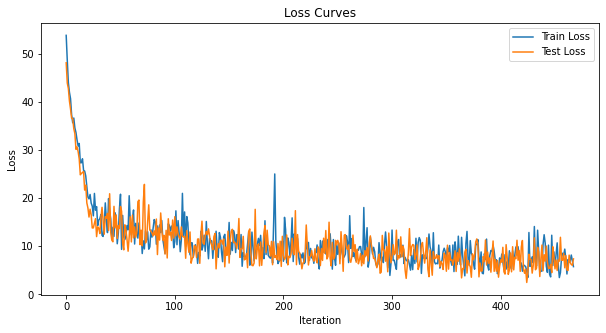

In [68]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [69]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9434/10000
Test Set Accuracy: 94.34%
